# Setup
We need datasets, dataloaders, and code to train and evaluate models

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [2]:
import os
import sys
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)
from models import *
from data_structures import *
from helpers import load_from_hdf5

In [3]:
X, y = load_from_hdf5(filename="../../engine_final_scaled.h5")

In [4]:
y_hs = X[:, 0, 44]
X = X[:, :, :44]
print(y_hs.shape)
print(X.shape)
print(y.shape)

(500000,)
(500000, 50, 44)
(500000,)


In [17]:
threshold = 20
idxs = np.where(y_hs < threshold)[0]
X_threshold = X[idxs]
y_threshold = y[idxs]

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# 1d CNN
First, let's try a one dimensional CNN to capture temporal relationships within each feature.

In [6]:
train_loader, test_loader = create_train_test_dataloaders(X, y)

Train set size: 400000, Test set size: 100000


In [7]:
num_feats = 44
model = CNNRULRegression(num_features=num_feats).to(device)
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.00001)
num_epochs = 20 
history = train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=num_epochs)

Epoch 1/20, Train Loss: 585.0929, Test Loss: 207.0237
Epoch 2/20, Train Loss: 111.5425, Test Loss: 99.4622
Epoch 3/20, Train Loss: 96.0884, Test Loss: 93.5042
Epoch 4/20, Train Loss: 90.5469, Test Loss: 87.9529
Epoch 5/20, Train Loss: 85.3175, Test Loss: 84.1862
Epoch 6/20, Train Loss: 80.5278, Test Loss: 78.3959
Epoch 7/20, Train Loss: 76.0247, Test Loss: 73.8195
Epoch 8/20, Train Loss: 72.1017, Test Loss: 70.2100
Epoch 9/20, Train Loss: 68.5156, Test Loss: 66.4956
Epoch 10/20, Train Loss: 65.2090, Test Loss: 63.2617
Epoch 11/20, Train Loss: 62.1371, Test Loss: 60.1744
Epoch 12/20, Train Loss: 59.2859, Test Loss: 59.7496
Epoch 13/20, Train Loss: 56.7660, Test Loss: 55.9526
Epoch 14/20, Train Loss: 54.5092, Test Loss: 53.0049
Epoch 15/20, Train Loss: 52.7743, Test Loss: 51.3134
Epoch 16/20, Train Loss: 51.0715, Test Loss: 51.8512
Epoch 17/20, Train Loss: 49.7112, Test Loss: 48.2181
Epoch 18/20, Train Loss: 48.4800, Test Loss: 47.5568
Epoch 19/20, Train Loss: 47.2836, Test Loss: 46.8072

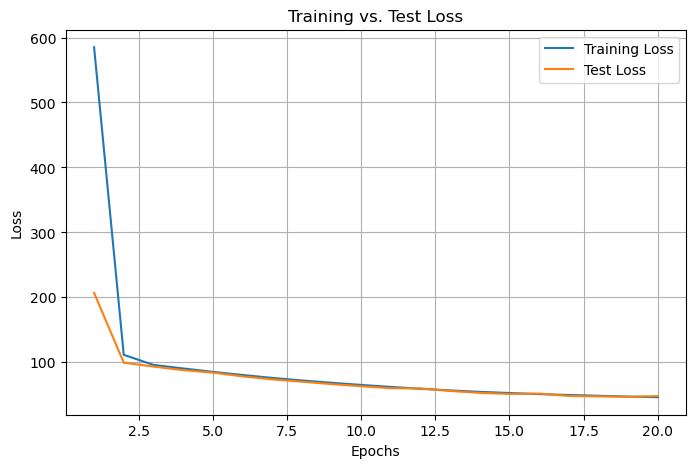

In [8]:
plot_loss(history)

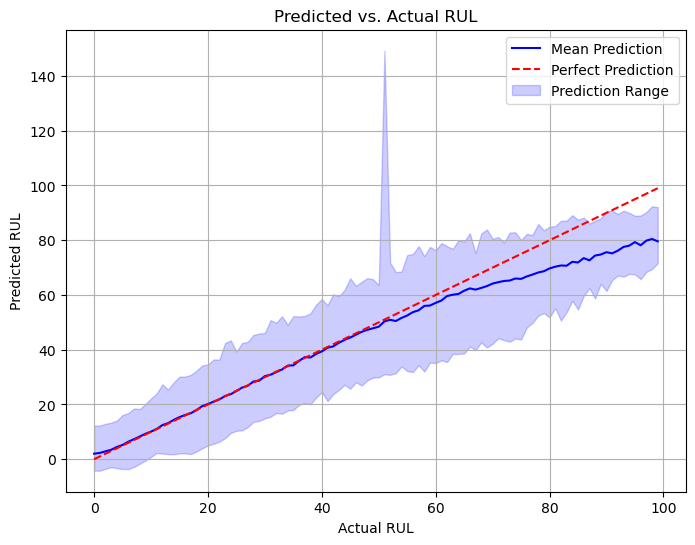

In [9]:
plot_rul_predictions(model, test_loader, device, aggregate=True, shaded_region=True)

In [10]:
torch.save(model.state_dict(), 'state_dicts/baseline_state_dict.pth')

# 2d CNN
Now, let's try out a two dimensional CNN to capture interactions among features.

In [11]:
train_loader, test_loader = create_train_test_dataloaders(X, y, dim="2d")

Train set size: 400000, Test set size: 100000


In [12]:
num_feats = 44
model = CNNRUL2DRegression(num_features=num_feats).to(device)
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.00001)
num_epochs = 20 

In [ ]:
history = train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=num_epochs)

Epoch 1/20, Train Loss: 481.4951, Test Loss: 133.3896


In [ ]:
plot_loss(history)

In [ ]:
plot_rul_predictions(model, test_loader, device, aggregate=True, shaded_region=True)

In [ ]:
torch.save(model.state_dict(), 'state_dicts/2d_baseline_state_dict.pth')

# Hybrid CNN
Now, let's try a hybrid CNN that uses both 1d and 2d convolutions.

In [6]:
train_loader, test_loader = create_train_test_dataloaders(X, y)

Train set size: 109735, Test set size: 27434


In [7]:
num_feats = 33
seq_length = 50  
model = HybridCNNRegression(num_features=num_feats, seq_length=seq_length).to(device)
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
num_epochs = 10
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.00001)

history = train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=num_epochs)

Epoch 1/10, Train Loss: 34.9332, Test Loss: 33.3268
Epoch 2/10, Train Loss: 33.0033, Test Loss: 32.6541
Epoch 3/10, Train Loss: 32.4246, Test Loss: 32.1917
Epoch 4/10, Train Loss: 31.8466, Test Loss: 31.4969
Epoch 5/10, Train Loss: 31.2137, Test Loss: 30.8002
Epoch 6/10, Train Loss: 30.4814, Test Loss: 30.0214
Epoch 7/10, Train Loss: 29.6644, Test Loss: 29.2290
Epoch 8/10, Train Loss: 28.7731, Test Loss: 28.2207
Epoch 9/10, Train Loss: 27.7560, Test Loss: 27.2286
Epoch 10/10, Train Loss: 26.6549, Test Loss: 26.0428


In [10]:
torch.save(model.state_dict(), 'regression_hybrid_state_dict.pth')

In [ ]:
state_dict = torch.load('regression_hybrid_state_dict.pth')
model = HybridCNNRegression(num_features=num_feats, seq_length=seq_length).to(device)
model.load_state_dict(state_dict)

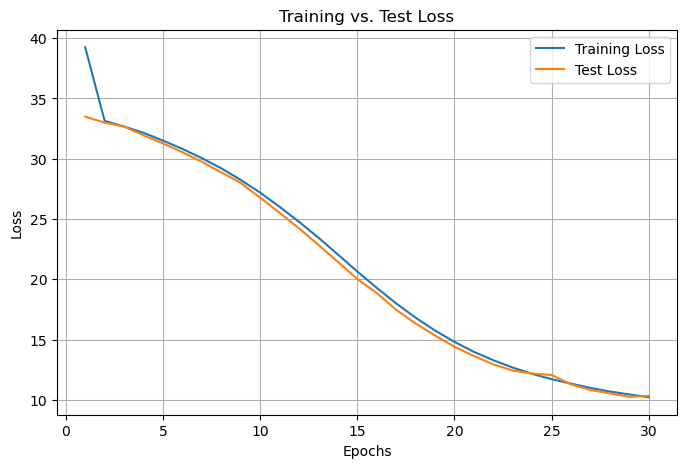

In [8]:
plot_loss(history)

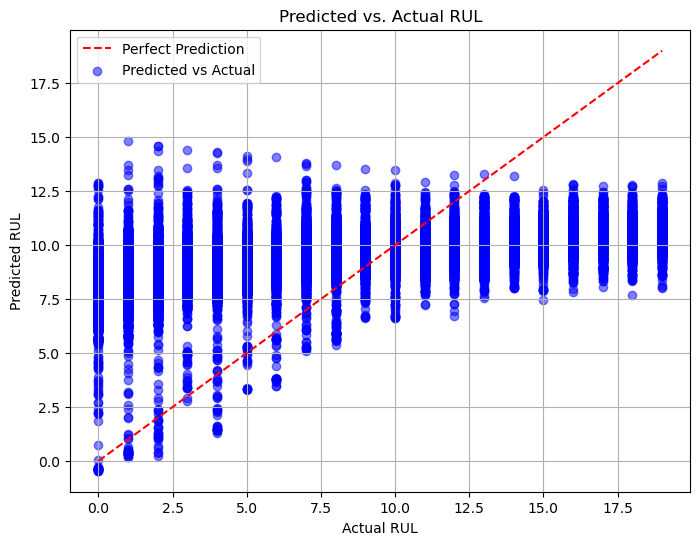

In [8]:
plot_rul_predictions(model, test_loader, device)

# Hybrid CNN with Custom Loss Function
Now, let's try a hybrid CNN that uses both 1d and 2d convolutions, this time with a custom loss function that penalizes overestimations more then underestimations.

In [10]:
num_feats = 33
seq_length = 50  
model = HybridCNNRegression(num_features=num_feats, seq_length=seq_length).to(device)
criterion = AsymmetricHuberLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
num_epochs = 10

history = train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=num_epochs)

Epoch 1/10, Train Loss: 7.5359, Test Loss: 7.4662
Epoch 2/10, Train Loss: 7.4500, Test Loss: 7.3875
Epoch 3/10, Train Loss: 7.3731, Test Loss: 7.3035
Epoch 4/10, Train Loss: 7.2797, Test Loss: 7.1988
Epoch 5/10, Train Loss: 7.1640, Test Loss: 7.0681
Epoch 6/10, Train Loss: 7.0226, Test Loss: 6.9231
Epoch 7/10, Train Loss: 6.8452, Test Loss: 6.7143
Epoch 8/10, Train Loss: 6.6369, Test Loss: 6.5294
Epoch 9/10, Train Loss: 6.4150, Test Loss: 6.2822
Epoch 10/10, Train Loss: 6.1715, Test Loss: 6.0240


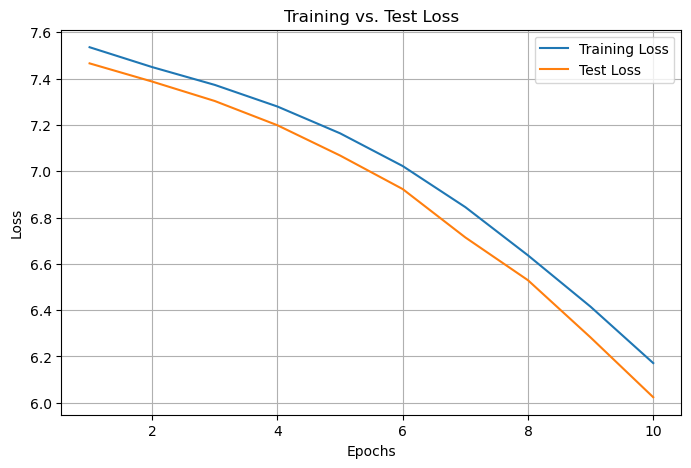

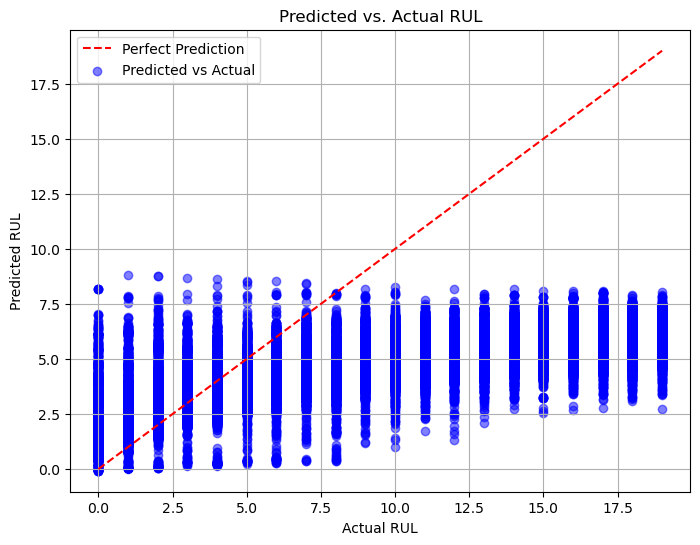

In [11]:
plot_loss(history)
plot_rul_predictions(model, test_loader, device)

# More Complex Hybrid Model
The model's loss dropping drastically and then remaining stable might indicate underfitting. So, let's try adding additional convolutional layers.

In [ ]:
num_feats = 44
seq_length = 50  
model = ComplexHybridCNNRegression(num_features=num_feats, seq_length=seq_length).to(device)
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
num_epochs = 15

history = train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=num_epochs)

In [ ]:
plot_loss(history)

In [ ]:
plot_rul_predictions(model, test_loader, device)

# Temporal CNN
Our more complex hybrid CNN was massively overfitting, so let's go in a different direction. Let's try a temporal CNN instead. 

In [ ]:
num_feats = 44
seq_length = 50
model = TCNRegression(num_features=num_feats, seq_length=seq_length).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
num_epochs = 20

history = train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=num_epochs)
plot_loss(history)

In [ ]:
plot_rul_predictions(model, test_loader, device)